# Trabalho Prático 01 (Detecção de Alvos Planos)
- Giovanna Louzi Bellonia - 2017086015
- Thiago Martin Poppe - 2017014324
<br><br>

__Obs.:__ Cada função possui uma descrição em Markdown e uma docstring contendo uma descrição breve, parâmetros (tipos e o que significam) e retorno.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from time import time

# Lendo o vídeo e salvando os frames em um numpy.array

In [2]:
# Lendo o vídeo
cap = cv2.VideoCapture('entrada.avi')

# Salvando os frames para um numpy array
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        print('*** Capture Finished ***')
        break
        
    frames.append(frame)

frames = np.array(frames)

*** Capture Finished ***


## Função show

- A função ___show___ foi definida para que pudessemos ver as imagens na célula do notebook sem que precisarmos abrir a janela extra do OpenCV, facilitando os testes e análises.

In [3]:
def show(img):
    """
        Exibe uma imagem, na própria célula, usando matplotlib
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem a ser exibida
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.show()

# Função is_in

- A função is_in verifica se algum ponto na vizinhança do ponto (x, y) é uma quina.
- O tamanho da vizinhança a ser analisada é passado para a função através do parâmetro _offset_. Note que serão _offset_ pixels à esquerda e à direita do ponto escolhido!

In [4]:
def is_in(x, y, offset, corners):
    """
        Verifica se existe alguma quina em volta de um dado ponto
        
        Parâmetros
        ----------
        x : int
            Valor da coordenada x do ponto
        
        y : int
            Valor da coordenada y do ponto
            
        offset : int
            Offset a ser usado para olhar ao redor do ponto
        
         corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
        Retorno
        -------
        tuple
            Se uma quina for encontrada, retorna a sua posição em uma tupla.
            Caso contrário, retorna a tupla (-1, -1)
    """
    
    for i in range(x - offset, x + offset + 1):
        for j in range(y - offset, y + offset + 1):
            if (i,j) in corners:
                return (i,j)
    return (-1,-1)

# Passo a passo do algoritmo desenvolvido:

## 1) Encontrando os pontos de quina

- Primeiramente, convertemos o frame atual para tons de cinza. Em seguida realizamos o seguinte procedimento:
    - Utilizamos o Harris Corner Detector, para detectar as quinas na nossa cena.
    - Filtramos as quinas deixando aquelas que são maiores que 20% da intensidade do valor máximo encontrado.
    - Calculamos o índice (i,j) de cada quina na imagem, salvando em uma lista chamada _corners_.
    - Pintamos de vermelho na imagem as quinas filtradas, e exibimos.

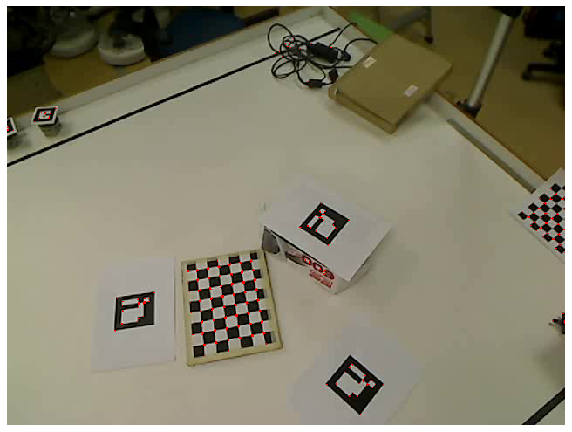

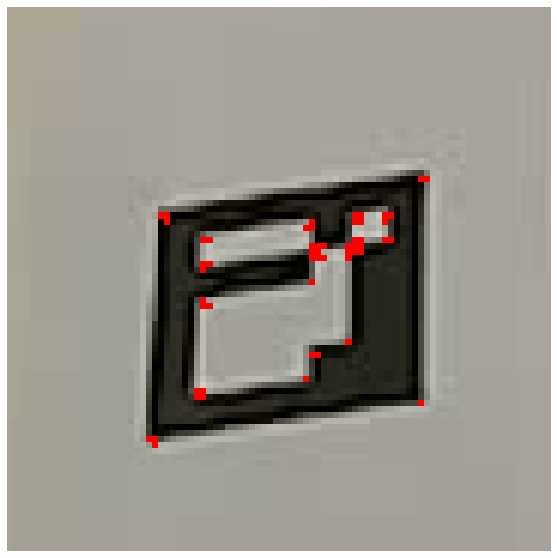

In [5]:
# Selecionando o primeiro frame
frame = frames[0].copy()

# Passando o frame escolhido para tons de cinza
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Aplicando Harris para detecção de quinas
gray = np.float32(gray)
harris = cv2.cornerHarris(gray, 2, 3, 0.04) 

# Extraindo pontos de quina
pts = harris > 0.15 * harris.max()
corners = [tuple((y, x)) for x,y in np.argwhere(pts == True)]

# Exibindo em vermelho os pontos de quina
img = frame.copy()
img[pts] = [0, 0, 255]

show(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
show(cv2.cvtColor(img[300:390, 100:190], cv2.COLOR_BGR2RGB))

## 2) Encontrando os pontos do alvo

__Obs.:__ Para fins de exemplo, executamos apenas para 1 ponto de quina

- Iremos executar o seguinte algoritmo para cada ponto de quina, até termos 4 pontos:
    - Inserimos o ponto lido na lista de pontos do possível alvo
    - Iremos andar 60 pixels em uma direção definida por um ângulo escolhido
    - Verificamos em torno de uma área em busca de quinas
    - Chamamos a função recursivamente para o novo ponto encontrado
    <br><br>
    
- Explicações sobre os ângulos escolhidos:
    - Sempre iremos percorrer o alvo no sentido anti-horário, logo, para o primeiro ponto iremos verificar possíveis quinas entre 0º e 90º. Para o segundo ponto, iremos verificar possíveis quinas entre 90º e 180º, e assim por diante.

Os pontos são: [(405, 468), (431, 433), (394, 400), (366, 433)]

Imagem da varredura


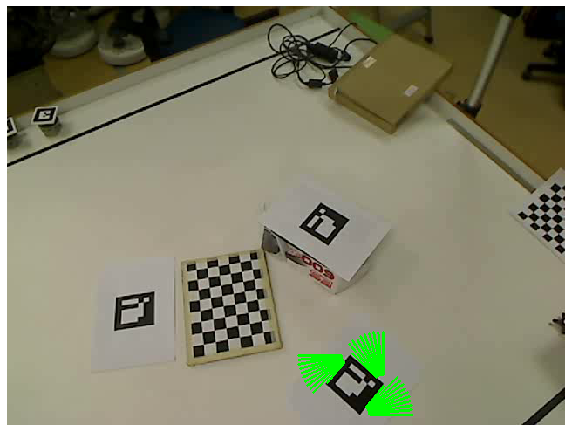


Imagem dos pontos


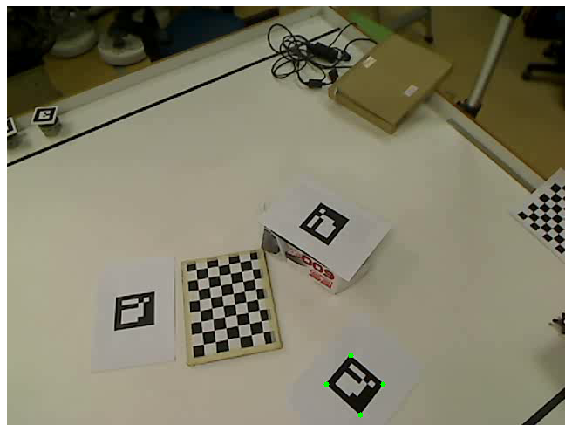

In [6]:
# Pegando o ponto de início e copiando o frame atual
p = corners[-1]
pt_img = frame.copy()
temp = frame.copy()

# Futuramente essa função será a função que usaremos para varrer a imagem em busca dos pontos (função scan)
# Teremos mais explicações sobre a mesma em células futuras
def scan_show(start, angle, corners, pts, start_check=10):
    
    # Adicionando o ponto à lista de pontos
    pts.append((int(start[0]), int(start[1])))
    
    # Iremos executar até termos 4 pontos, já que o alvo é um quadrilátero
    if len(pts) < 4:
        for j in range(angle, angle+91, 5):
            
            # Calculando a matriz de rotação
            rot = np.float32([
                [np.cos(j * np.pi/180), -np.sin(j * np.pi/180)],
                [np.sin(j * np.pi/180),  np.cos(j * np.pi/180)]
            ])

            # Definindo o ponto atual e a direção a ser andada
            current = np.float32([[start[0]], [start[1]]]).T
            direction = np.float32([[1], [0]]).T @ rot
            
            
            
            current += 10 * direction
            for _ in range(50):
                current += direction
                cv2.circle(temp, tuple((int(current[0][0]), int(current[0][1]))), 1, (0,255,0), -1)
                
                # Caso o ponto for quina, chamamos a função recursivamente para aquele ponto
                pt = is_in(int(current[0][0]), int(current[0][1]), 2, corners)
                if pt != (-1,-1):
                    return scan_show(np.float32([pt[0], pt[1]]), angle+90, corners, pts)
    return pts

# Executando a função
pts = []
pts = scan_show(p, 0, corners, pts)

for p in pts:
    cv2.circle(pt_img, p, 3, (0, 255 ,0), -1)

print('Os pontos são:', pts)
print('\nImagem da varredura')
show(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))

print('\nImagem dos pontos')
show(cv2.cvtColor(pt_img, cv2.COLOR_BGR2RGB))

## 3) Aplicando a homografia
__Obs.:__ Percebemos que o .jpg do alvo não era exatamente quadrado. Então, fizemos um crop para que o mesmo ficasse com dimensões de 310x310 pixels.

- Iremos executar o seguinte algoritmo:
    - Lemos o alvo, calculando suas dimensões.
    - Estimamos a matriz de homografia usando o método RANSAC para filtrar erros grosseiros e aplicamos o warpPerspective.
    - Binarizamos o resultado obtido.

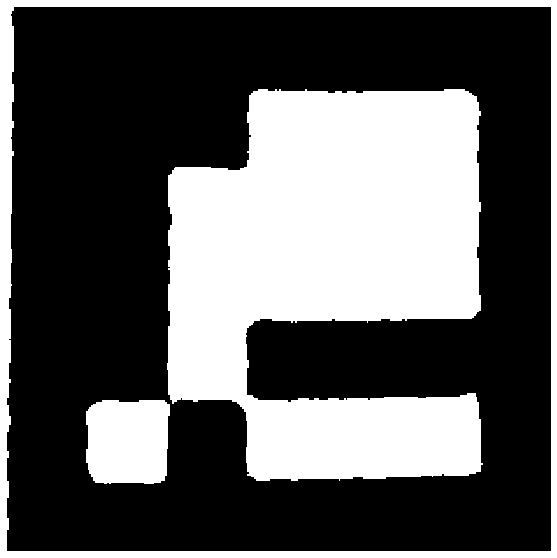

(310, 310)

In [7]:
# Lendo o alvo e obtendo suas dimensões
target = cv2.imread('alvo.jpg')
dim_alvo = np.float32([[0,0], [0, target.shape[1]], [target.shape[0], target.shape[1]], [target.shape[0], 0]])

# Estimando a matriz de homografia e realizando o warpPerspective
M = cv2.findHomography(np.float32(pts), dim_alvo, cv2.RANSAC)[0]
result = cv2.warpPerspective(gray, M, (target.shape[0], target.shape[1]))

# Binarizando o resultado
result[result < 80] = 0
result[result >= 80] = 255

# Exibindo a imagem e as suas dimensões
show(result)
result.shape

## 4) Rotacionando os alvos

- Rotacionamos o alvo em 0º, 90º, 180º e 270º para realizar posteriormente o template matching, pois o alvo pode estar rotacionado na cena.

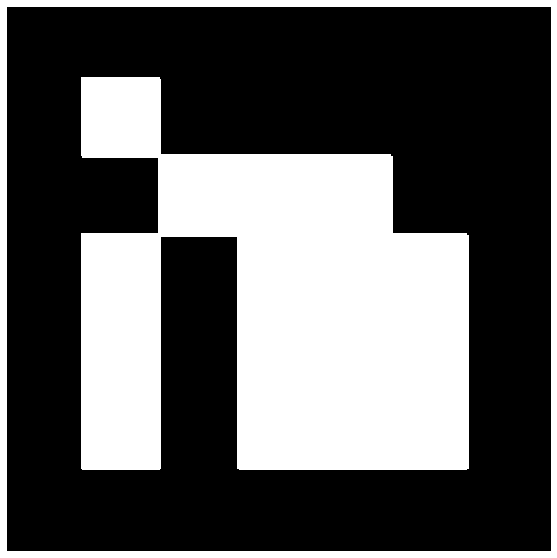

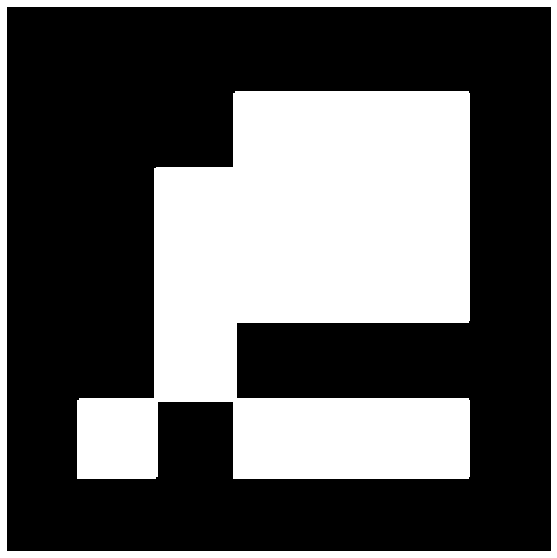

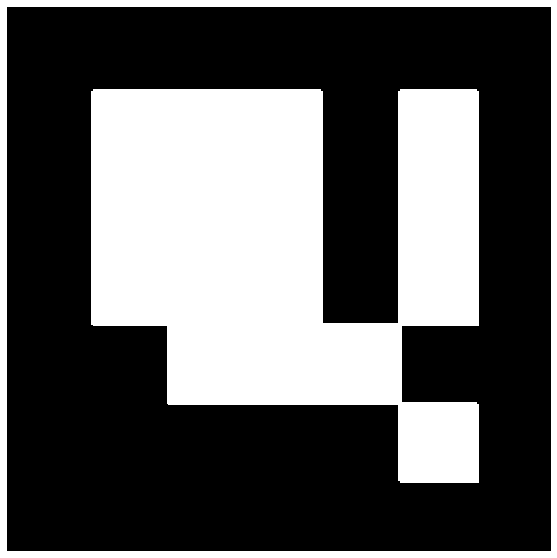

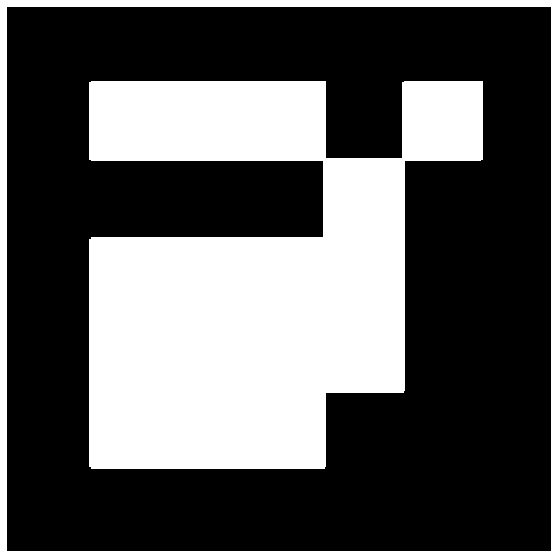

In [8]:
# Convertendo o alvo para tons de cinza e binarizando o mesmo
target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
target[target < 25] = 0
target[target >= 25] = 255

# Criando uma lista para os alvos rotacionados
targets = []

# Rotacionando o alvo em cada um dos ângulos e salvando em uma lista
for angle in [0, 90, 180, 270]:
    M = cv2.getRotationMatrix2D((target.shape[1]/2, target.shape[0]/2), angle, 1)
    targets.append(cv2.warpAffine(target, M, (target.shape[0], target.shape[1])))

for target in targets:
    show(target)

## 5) Realizando o template matching

- Realizando o processo de template matching usando a diferença absoluta média dos pixels.
- Caso esse casamento tenha valor menor ou igual à 25, aceitamos como um casamento válido.

In [9]:
for i,target in enumerate(targets):
    match = np.sum(np.abs(target - result)) / (target.size)
    if match <= 25:
        print('Casamento bem-sucedido com o alvo rotacionado em', i * 90, 'graus')

Casamento bem-sucedido com o alvo rotacionado em 90 graus


## 6) Colorindo as bordas do alvo

- Borda de cima $\rightarrow$ Azul
- Borda debaixo $\rightarrow$ Vermelha
- Borda da esquerda $\rightarrow$ Verde
- Borda da direita $\rightarrow$ Ciano

__Obs1.:__ Note que devemos para cada rotação do alvo, pintar as bordas em uma ordem diferente!<br>
__Obs2.:__ Temos que informar a cor em BGR devido à OpenCV ser assim.

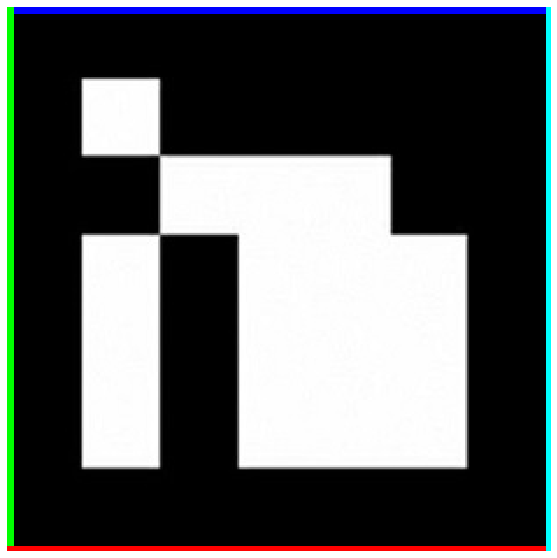

In [10]:
# Lendo novamente o alvo (apenas para exemplo)
target = cv2.imread('alvo.jpg')
img = target.copy()

# Definindo as cores
blue = (255,0,0)
green = (0,255,0)
red = (0,0,255)
cyan = (255,255,0)

# Desenhando as linhas em torno do alvo para exemplificar
cv2.line(img, (0,0), (310,0), blue, 5)
cv2.line(img, (0,0), (0,310), green, 5)
cv2.line(img, (0,310), (310,310), red, 5)
cv2.line(img, (310,310), (310,0), cyan, 5)

show(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

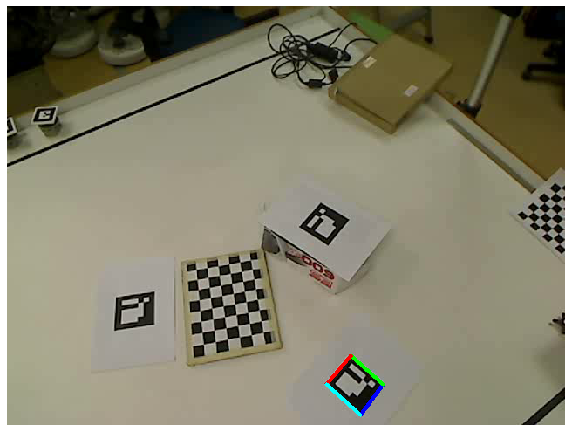

In [11]:
# Desenhando as linhas em torno do alvo na cena
img = frame.copy()
cv2.line(img, pts[0], pts[1], blue, 3)
cv2.line(img, pts[1], pts[2], green, 3)
cv2.line(img, pts[2], pts[3], red, 3)
cv2.line(img, pts[3], pts[0], cyan, 3)

show(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 7) Resumo do algoritmo e algumas observações

- Agora que já temos todo o pipeline para encontrarmos os alvos em um frame, basta rodarmos o algoritmo para cada frame do vídeo!

- Definiremos a seguir, de forma mais concreta, as funções utilizadas, informando seus parâmetros e valores de retorno (caso tenham).
<br>

- Infelizmente a função ___scan___ não é tão rápida assim... Por isso, criaremos uma função scan_optimized, que dado os pontos onde potencialmente os alvos estão, analisaremos a redondeza desses pontos em busca de pontos de quina. Passaremos os pontos encontrados no frame anterior, visto que a mudança da cena um frame para o outro não é tão brusca.
<br>

- Com isso temos o seguinte algoritmo completo:
    1. Procuramos os alvos na cena utilizando a função ___scan___, que retornará os pontos encontrados.
    2. Para o próximo frame, usaremos os pontos obtidos anteriormente realizando a varredura usando a função scan_optimized.
    3. Caso a função otimizada não retorne 3 conjuntos de pontos (em outras palavras, 3 alvos), devemos executar a ___scan___ na cena.
    4. Fazemos isso até analisarmos todos os frames do vídeo.

# Explicação sobre as funções utilizadas

## 1) Função cross

- Apenas uma função auxiliar que fizemos para calcular o produto vetorial entre dois vetores centrados em (0, 0).
- Usaremos essa função mais a frente para calcular a orientação de um vetor em relação a outro (à direita ou à esquerda).

In [12]:
def cross(p0, p1):
    """
        Calcula o produto vetorial entre dois vetores centrados no (0, 0)
        
        Parâmetros
        ----------
        p0 : tuple
            Primeiro vetor
        
        p1 : tuple
            Segundo vetor
            
        Retorno
        -------
        float
            Retorna um número. Caso esse número seja positivo, o primeiro
            vetor está a direita do segundo; caso seja negativo, está a 
            esquerda
    """
    
    return p0[0]*p1[1] - p0[1]*p1[0]

## 2) Função diff

- Apenas uma função auxiliar que fizemos para calcular a diferença entre dois vetores.

In [13]:
def diff(p0, p1):
    """
        Calcula a diferença entre dois vetores
        
        Parâmetros
        ----------
        p0 : tuple
            Primeiro vetor
        
        p1 : tuple
            Segundo vetor
            
        Retorno
        -------
        tuple
            Retorna o primeiro vetor menos o segundo
    """
    
    return (p0[0] - p1[0], p0[1] - p1[1])

## 3) Função right

- Apenas uma função auxiliar que fizemos para nos dizer se um ponto está à direita de uma reta (usando a função cross e diff)

In [14]:
def right(p0, p1, p):
    """
        Retorna True caso o ponto esteja a direita do vetor p0p1 e False caso contrário
        
        Parâmetros
        ----------
        p0 : tuple
            Primeiro vetor
        
        p1 : tuple
            Segundo vetor
            
        p : tuple
            Ponto a ser analisado
            
        Retorno
        -------
        bool
            True  -> o ponto está a direita do vetor
            False -> o ponto está a esquerda do vetor
    """
    
    return cross(diff(p, p0), diff(p1, p0)) < 0

## 4) Função out_target

- Fizemos essa função para retornar True caso o ponto esteja fora de um quadrilátero (no caso o nosso alvo), e False caso o mesmo esteja dentro.
- Faremos isso basicamente percorrendo as bordas do alvo no sentido anti-horário, verficando se o ponto está a direita de alguma delas.
- Usaremos essa função como uma forma de otimizar a varredura, eliminando quinas que estão dentro do alvo, já que não precisaremos mais delas.

In [15]:
def out_target(target, p):
    """
        Retorna True caso o ponto esteja dentro do alvo e False caso contrário.
        
        Parâmetros
        ----------
        target : tuple list
            Lista de pontos que indicam os cantos do alvo
            
        p : tuple
            Ponto a ser analisado
            
        Retorno
        -------
        bool
            True  -> o ponto está fora do alvo
            False -> o ponto está dentro do alvo
    """
    
    return right(target[0], target[1], p) or \
           right(target[1], target[2], p) or \
           right(target[2], target[3], p) or \
           right(target[3], target[0], p)

## 5) Função find_corners

- Função criada para retornar uma lista de índices das quinas calculadas pelo Harris Corner Detector. Dessa forma, não precisamos percorrer a imagem inteira em busca das mesmas, basta percorrermos essa lista de quinas.

In [16]:
def find_corners(frame, harris_tol):
    """
        Encontra as quinas de um dado frame usando o Harris Corner Detector
        
        Parâmetros
        ----------
        frame : numpy.ndarray
            Frame a ser analisado
        
        harris_tol : float
            Tolerância usada para considerar quina
            
        Retorno
        -------
        tuple list
            Uma lista de pontos com as quinas
    """
    
    # Aplicando harris para detecção de quinas
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    harris = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    
    # Extraindo pontos de quina
    pts = harris > harris_tol * harris.max()
    pts_corner = [(y,x) for x,y in np.argwhere(pts == True)]
    
    return pts_corner

## 6) Função homography

- Função criada para estimar a matriz de homografia utilizando a função findHomography com o método RANSAC para filtrar erros grosseiros e a função warpPerspective para aplicar tal matriz na imagem.
- Irá retornar o resultado binarizado para realizarmos posteriormente um template matching mais preciso.

In [17]:
def homography(img, src, target):
    """
        Estima e aplica a matriz de homografia em um conjunto de pontos
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem de onde os pontos foram extraídos
            
        src : numpy.ndarray
            Pontos de origem (da imagem)
            
        target : numpy.ndarray
            Pontos do alvo
            
        Retorno
        -------
        numpy.ndarray
            Retorna aquela parte da imagem binarizada e com a homografia aplicada
    """
    
    # Obtendo os pontos no alvo e estimando a matriz de homografia usando RANSAC
    dst = np.float32([[0,0], [0, target.shape[1]], [target.shape[0], target.shape[1]], [target.shape[0], 0]])
    M = cv2.findHomography(src, dst, cv2.RANSAC)[0]
    
    # Aplicando o warpPerspective e binarizando a imagem
    result = cv2.warpPerspective(img, M, (target.shape[0], target.shape[1]))
    result[result < 80] = 0
    result[result >= 80] = 255
    
    return result

## 7) Função similarity_func

- Função criada para retornar o quão similar duas imagens são.
- Fizemos um cálculo de diferença média absoluta dos pixels para tal.

In [18]:
def similarity_func(img1, img2):
    """
        Função de similaridade usando a diferença média dos pixels
        
        Parâmetros
        ----------
        img1 : numpy.ndarray
            Imagem 1 a ser comparada
            
        img2 : numpy.ndarray
            Imagem 2 a ser comparada
            
        Retorno
        -------
            Retorna o valor da diferença média dos pixels
    """
    
    return np.sum(np.abs(img1 - img2)) / (img1.size)

## 8) Função scan

- Função criada para realizar uma varredura na cena, procurando os possíveis alvos.
- Inicialmente pensamos em fazer uma varredura em 360º em torno do ponto atual, mas percebemos que isso não é necessário. Como definimos que estamos realizando a varredura no sentido anti-horário, basta ao encontrarmos um ponto, observar o quadrante definido por angle e angle + 90º. Tornando assim, a procura bem mais rápida.
- Como sabemos que nosso alvo é quadrado, paramos assim que encontramos 4 pontos.

In [19]:
def scan(start, start_angle, corners, pts, step, start_check, angle):
    """
        Realiza uma varredura no sentido anti-horário na imagem,
        começando de `angle` até `angle` + 90º à procura de quinas
        
        Parâmetros
        ----------
        start : tuple
            Ponto inicial da varredura
            
        start_angle : int
            Ângulo inicial da varredura
        
        corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
        pts : list
            Lista de pontos que foram lidos como quina até o momento
            
        step : int
            Define o quanto iremos andar (em pixels) seguindo aquela direção
            
        start_check : int
            Valor para começar a verificar se o pixel é quina (define o ponto de partida)
            
        angle : int
            Define o quanto, em graus, iremos mudar a direção 
            
        Retorno
        -------
        tuple list
            Lista de tuplas de pontos que foram lidos como quinas pela função
    """
    
    # Adicionando o ponto à lista de pontos
    pts.append(start)
    
    # Iremos executar até termos 4 pontos, já que o alvo é um quadrilátero
    if len(pts) < 4:
        for theta in range(start_angle, start_angle+91, angle):
            
            # Definindo a matriz de rotação
            theta *= np.pi / 180
            rot = np.float32([
                [np.cos(theta), -np.sin(theta)],
                [np.sin(theta),  np.cos(theta)]
            ])
            
            # Definindo o ponto atual e a direção a ser andada
            current = np.float32([[start[0]], [start[1]]]).T
            direction = np.float32([[1], [0]]).T @ rot
            
            # Começando start_check pixels a frente 
            current += start_check * direction
            
            # Loop para andarmos 'step' pixels naquela direção
            for _ in range(step):
                current += direction
                
                # Caso o ponto for quina, chamamos a função recursivamente para aquele ponto
                pt = is_in(int(current[0][0]), int(current[0][1]), 2, corners)
                if pt != (-1,-1):
                    return scan(pt, start_angle+90, corners, pts, step, start_check, angle)
                
    return pts

## 9) Função get_targets

- Função auxiliar usada para ler o arquivo que contêm o alvo, retornando o mesmo rotacionado em 0º, 90º, 180º e 270º respectivamente.

In [20]:
def get_targets(filename):
    """
        Retorna o alvo rotacionado em 0º, 90º, 180º e 270º
        
        Parâmetros
        ----------
        filename : str
            Nome do arquivo, .jpg por exemplo, do alvo
            
        Retorno
        -------
        list
            Lista contendo o alvo rotacionado em 0º, 90º, 180º e 270º (nessa ordem)
    """
    
    # Lendo o alvo, convertendo para escalas de cinza e binarizando
    target = cv2.imread(filename)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    target[target < 25] = 0
    target[target >= 25] = 255
    
    targets_list = []
    
    # Rotacionando o alvo em cada um dos ângulos e salvando em uma lista
    for angle in [0, 90, 180, 270]:
        M = cv2.getRotationMatrix2D((target.shape[1]/2, target.shape[0]/2), angle, 1)
        targets_list.append(cv2.warpAffine(target, M, (target.shape[0], target.shape[1])))
                            
    return targets_list

## 10) Função draw_contour

- Função auxiliar criada para desenhar o contorno em volta do alvo, usando as cores passadas como parâmetro para a função em formato BGR.

In [21]:
def draw_contour(img, pts, colors, thickness=2):
    """
        Desenha um contorno na imagem dado os pontos
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem onde será desenhado
            
        pts : tuple list
            Lista de tuplas com os pontos que definem o contorno
            
        colors : tuple list
            Lista de tuplas com as cores de cada lado do contorno (em BGR)
            
        thickness : int, opcional
            Grossura do contorno (por padrão são 2 pixels)            
    """
    
    cv2.line(img, pts[0], pts[1], colors[0], thickness)
    cv2.line(img, pts[1], pts[2], colors[1], thickness)
    cv2.line(img, pts[2], pts[3], colors[2], thickness)
    cv2.line(img, pts[3], pts[0], colors[3], thickness)

## 11) Função template_matching

- Essa função cumpre o papel de, para cada imagem do alvo rotacionado, verificar o quão similar ela é com a imagem obtida no passo da homografia. Salvando o índice da imagem que possui o menor valor retornado pela função similarity_func, em outras palavras, a mais similar.
- Caso essa imagem não possua valor de similaridade menor do que a tolerância definida, não aceitamos e retornamos -1. Caso contrário, retornamos o índice encontrado.

In [22]:
def template_matching(img, targets, sim_func, tol=25):
    """
        Função que realiza o casamento de template
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem que se quer casar
            
        targets : numpy.ndarray list
            Lista de alvos que iremos casar
            
        simFunc : function
            Função de similaridade que aceita dois numpy.ndarray,
            realiza os cálculos e retorna um número
            
        tol : float, opcional
            Tolerância para ser um casamento válido (por padrão é 20)
            
        Retorno
        -------
        int
            Caso o valor de similaridade esteja abaixo da tolerância,
            retornamos o índice do alvo que resultou em um casamento
            bem-sucedido (seguindo a mesma ordem dos ângulos).
            Senão, retornamos -1.
    """
    
    min_similarity = sim_func(img, targets[0])
    min_pos = 0
    
    # Caminhando por cada alvo, comparando o valor de similaridade do atual e 
    # atualizando, caso necessário, as variáveis
    for i in range(1, len(targets)):
        current = sim_func(img, targets[i])
        if current < min_similarity:
            min_similarity = current
            min_pos = i
    
    return min_pos if min_similarity <= tol else -1

## 12) Função remove_neighbors

- Essa função foi criada com o propósito de otimizar a varredura.
- Nela, iremos para cada ponto (x, y) remover os pontos de quina que se encontram ao redor da mesma num "raio" definido por ksize, que por padrão é 2.

In [23]:
def remove_neighbors(x, y, corners, ksize=2):
    """
    Função que remove os pontos de quina em torno do ponto (x, y) em
    um raio definido pelo parâmetro ksize

    Parâmetros
    ----------
    x : int
        Coordenada x do ponto na imagem

    y : int
        Coordenada y do ponto na imagem

    corners : tuple list
            Lista de tuplas dos pontos que são quinas

    ksize : int, opcional
        "Raio" de captura em torno do ponto (por padrão é 2)
    """
    
    for i in range(x - ksize, x + ksize + 1):
        for j in range(y - ksize, y + ksize + 1):
            try:
                corners.remove((i,j))
            except:
                pass

## 13) Função filter_corners

- Essa função foi criada com o propósito de otimizar a varredura.
- Nela, iremos utilizar a função remove_neighbors para remover os pontos de quina do alvo, e a função out_target para remover os pontos internos do alvo (que não são necessários).
- Para filtrar as quinas, usamos a função "filter", nativa de Python que retorna os elementos de uma lista que satisfazem uma condição. No nosso caso, retorna os pontos que estão fora do alvo.

In [24]:
def filter_corners(target_pts, corners):
    """
    Função que remove os pontos da vizinhança das quinas
    dos alvos reconhecidos, e seus pontos internos
    
    Parâmetros
    ----------
    target_pts : list of tuple list
        Lista contendo a posição dos alvos encontrados
    
    corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
    Retorno
    -------
    tuple list
        Lista dos pontos de quina filtrados (caso necessário)
    """
    
    # Iremos rodar o código apenas se encontramos alvos
    if len(target_pts) != 0:
        
        # Para cada conjunto de pontos dentro de target_points,
        # removeremos os pontos do alvo na lista de quina
        for pts in target_points:
            for p in pts:
                remove_neighbors(p[0], p[1], corners)
                
            # Removendo os pontos internos do alvo na lista de quinas
            corners = list(filter(lambda p: out_target(pts, p), corners))
    
    return corners

## 14) Função seek_targets

- Função que condensa todo o pipeline. Desde varrer a cena em busca dos alvos, até a homografia e template matching, desenhando as bordas do alvo caso dê um casamento bem-sucedido.
- Ela possui algumas "otimizações", como veremos a seguir:
    - Iremos percorrer a lista de quinas no sentido reverso, sempre fazendo a varredura no sentido anti-horário. Sabendo que temos 2 alvos mais embaixo e apenas 1 em cima, isso fará com que não precisemos rodar o algoritmo para alguns pontos acima do alvo mais superior.
    - Usando o parâmetro num_targets, assim que encontramos a quantidade de alvos esperados, podemos parar a procura, assim tornando o processo mais rápido, ao desconsiderarmos alguns pontos no restante da cena.
    - Sempre estaremos removendo quinas na vizinhança do ponto inicial. Caso encontremos o alvo, iremos remover as quinas do mesmo e todas as quinas internas.
    - Ao dar match com o template, iremos colorir o alvo de acordo com sua orientação.
    - Retornamos os pontos encontrados, que servirão de input para a função a seguir.

In [25]:
def seek_targets(img, corners, step, start_check, angle, num_targets=3):
    """
        Procura os alvos em uma imagem, desenhando um
        contorno colorido no mesmo. A seguir, temos as
        cores de cada lado do contorno:
        
        Cima --> Azul
        Baixo --> Vermelho
        Esquerda --> Verde
        Direita --> Ciano
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem para realizar a busca
            
        corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
        step : int
            Define o quanto iremos andar (em pixels) seguindo aquela direção
            
        start_check : int
            Valor para começar a verificar se o pixel é quina (define o ponto de partida)
            
        angle : int
            Define o quanto, em graus, iremos mudar a direção
            
        num_targets : int, opcional
            Número de alvos na cena (por padrão são 3 alvos)
    
        Retorno
        -------
        list of tuple list
            Lista contendo a posição dos alvos encontrados
    """
    
    # Obtendo a imagem em escalas de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Defina aqui o nome do arquivo que contém uma imagem do alvo!
    targets = get_targets('alvo.jpg')
    
    # Definindo as cores de cada lado do contorno (em BGR)
    red = (0,0,255)
    green = (0,255,0)
    blue = (255,0,0)
    cyan = (255,255,0)
    
    # Lista para guardar os pontos das quinas dos alvos
    target_pts = []
    
    # Invertendo a lista de quinas e percorrendo cada ponto dela
    corners.reverse()
    while len(corners) != 0:
        # Realizando a varredura sobre aquele ponto
        pts = []
        pts = scan(corners[0], 0, corners, pts, step, start_check, angle)
        
        # Caso encontremos 4 pontos, realizamos a homografia e o template matching
        if len(pts) == 4:
            result = homography(np.float32(gray), np.float32(pts), targets[0])
            match = template_matching(result, targets, similarity_func)
            
            # Caso onde temos um match
            if match != -1:
                
                # Adicionando os pontos do alvo
                target_pts.append(pts)
                
                # Removendo os pontos do alvo na lista de quinas
                for p in pts:
                    remove_neighbors(p[0], p[1], corners)
                
                # Removendo os pontos internos do alvo na lista de quinas
                corners = list(filter(lambda p: out_target(pts, p), corners))
                
                # Definindo a forma de colorir o contorno em cada caso de match
                if match == 0:
                    draw_contour(img, pts, [green, red, cyan, blue])
                if match == 1:
                    draw_contour(img, pts, [blue, green, red, cyan])
                if match == 2:
                    draw_contour(img, pts, [cyan, blue, green, red])
                if match == 3:
                    draw_contour(img, pts, [red, cyan, blue, green])
                
                # Diminuindo em 1 o número de alvos a serem procurados.
                # Caso for 0, podemos parar a procura
                num_targets -= 1
                if num_targets == 0:
                    break
                    
        # Removendo as quinas em torno do ponto inicial daquela varredura
        remove_neighbors(pts[0][0], pts[0][1], corners)
                    
    return target_pts

## 15) Função scan_optimized

- A função é bem semelhante à função seek_target, porém não realizamos a varredura na imagem. 
- Nós assumimos que já sabemos onde estão os pontos de interesse do frame anterior. Com isso, visto que do frame n para o n+1 a composição da imagem não muda muito, podemos olhar em torno daqueles pontos procurando pontos de quina!
- Com isso, encontraremos os alvos de forma bem mais rápida!

__Obs.:__ Essa função também retorna os pontos encontrados, servindo assim de input para futuras chamadas.

In [26]:
def scan_optimized(img, corners, target_pts, ksize=3):
    """
        Procura os alvos em uma imagem, desenhando um
        contorno colorido no mesmo. A seguir, temos as
        cores de cada lado do contorno:
        
        Cima --> Azul
        Baixo --> Vermelho
        Esquerda --> Verde
        Direita --> Ciano
        
        Parâmetros
        ----------
        img : numpy.ndarray
            Imagem para realizar a busca
            
        corners : tuple list
            Lista de tuplas dos pontos que são quinas
            
        target_pts : list of tuple list
            Lista contendo a posição dos alvos encontrados no frame anterior
        
        ksize : int, opcional
            Tamanho da vizinhança a ser procurado os pontos de quina
    
        Retorno
        -------
        list of tuple list
            Lista contendo a posição dos alvos encontrados no frame atual
    """
    
    # Pré-processamento dos pontos recebidos pela função,
    # encontrando as quinas mais próximas dos mesmos
    target_list = []
    for pts in target_pts:
        aux = []
        
        for p in pts:
            point = is_in(p[0], p[1], ksize, corners)
            if point != (-1, -1):
                aux.append(point)
        
        target_list.append(aux)

    # Obtendo a imagem em escalas de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Defina aqui o nome do arquivo que contém uma imagem do alvo!
    targets = get_targets('alvo.jpg')
    
    # Definindo uma lista vazia para os novos pontos de quina
    # dos alvos da cena
    new_target_pts = []
    
    # Definindo as cores de cada lado do contorno (em BGR)
    red = (0,0,255)
    green = (0,255,0)
    blue = (255,0,0)
    cyan = (255,255,0)
    
    for target in target_list:
        if len(target) == 4:
            result = homography(np.float32(gray), np.float32(target), targets[0])
            match = template_matching(result, targets, similarity_func)
            
            # Caso onde temos um match
            if match != -1:
                
                # Adicionando os pontos do alvo
                new_target_pts.append(target)
                
                # Definindo a forma de colorir o contorno em cada caso de match
                if match == 0:
                    draw_contour(img, target, [green, red, cyan, blue])
                if match == 1:
                    draw_contour(img, target, [blue, green, red, cyan])
                if match == 2:
                    draw_contour(img, target, [cyan, blue, green, red])
                if match == 3:
                    draw_contour(img, target, [red, cyan, blue, green])
                    
    return new_target_pts

# Resultados
## 1) Exemplo da função seek_targets aplicada ao frame 0

- Aqui temos um exemplo da função seek_targets aplicada ao primeiro frame e o tempo que demorou para executarmos.

Demorou: 43.84741497039795 segundos


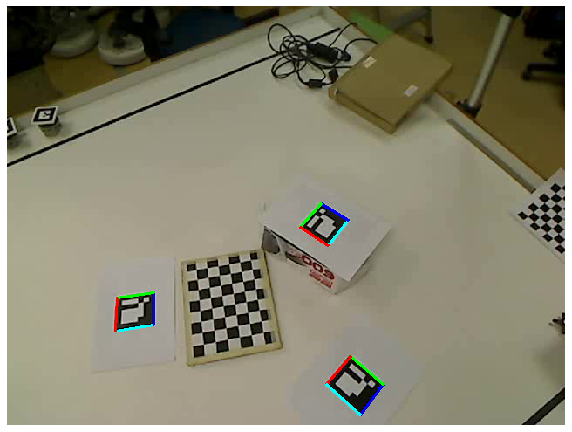

In [27]:
# Fazendo uma cópia do frame 0 e achando suas quinas
frame = frames[0].copy()
corners = find_corners(frame, 0.2)

# Rodando a função, computando o tempo que demorou em segundos
start = time()
pts = seek_targets(frame, corners, step=50, start_check=10, angle=10)
end = time()

# Exibindo os resultados
print('Demorou:', end - start, 'segundos')
show(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## 2) Exemplo da função scan_optimized aplicada ao frame 1

Demorou: 0.1495048999786377 segundos


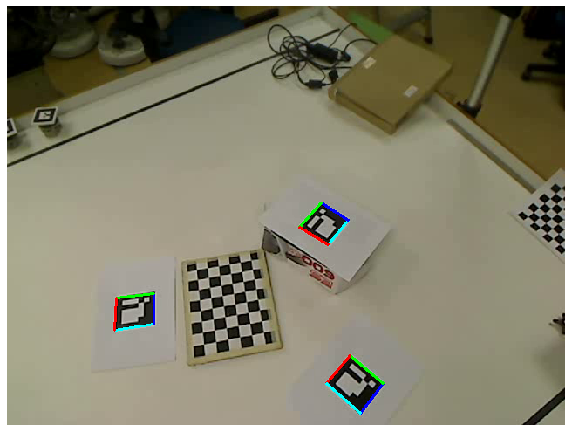

In [28]:
# Recebendo os pontos computados no passo anterior
target_points = pts

# Fazendo uma cópia do frame 1 e achando suas quinas
frame = frames[1].copy()
corners = find_corners(frame, 0.01)

# Rodando a função, computando o tempo que demorou em segundos
start = time()
pts = scan_optimized(frame, corners, target_points)
end = time()

# Exibindo os resultados
print('Demorou:', end - start, 'segundos')
show(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## 3) Exemplificando para os primeiros 300 frames

- Aqui, temos um exemplo do processo de detecção dos alvos usando a nossa abordagem.
- Fizemos para os primeiros 300 frames caso queira rodar e observar o que acontece. Caso queira mudar o intervalo de frames processados, basta mudar as variáveis start_frame e end_frame.
- Esse código costuma demorar em média 140 segundos para os 300 frames iniciais.

In [29]:
start_frame = 0
end_frame   = 300
num_targets = 3

# Selecionando os frames que desejamos
selected = frames[start_frame:end_frame].copy()
target_pts = []

# Salvando o tempo inicial
start = time()

# Iterando pelos frames
for i, frame in enumerate(selected):
    
    # Encontrando as quinas da cena e fazendo a varredura otimizada
    corners = find_corners(frame, 0.01)
    target_pts = scan_optimized(frame, corners, target_pts)
    
    # Apenas um print para informar o progresso
    print('Analisando o frame', i+1)
    
    # Caso a varredura otimizada não encontra nenhum alvo, usamos a varredura normal
    if len(target_pts) < num_targets:
        corners = find_corners(frame, 0.15)
        corners = filter_corners(target_pts, corners)
        N = num_targets - len(target_pts)
        target_pts = seek_targets(frame, corners, step=50, start_check=10, angle=10, num_targets=N)
        
        # Esse caso é mais obscuro... Possivelmente não encontramos alvos por que andamos pouco!
        # Logo, usamos a varredura normal mais uma vez, porém com um "head start" maior
        if len(target_pts) < num_targets:
            corners = find_corners(frame, 0.15)
            corners = filter_corners(target_pts, corners)
            N = num_targets - len(target_pts)
            target_pts = seek_targets(frame, corners, step=50, start_check=40, angle=5, num_targets=N)
        

# Exibindo o tempo que demorou para rodar o algoritmo
print('Demorou', time() - start, 'segundos!')

Analisando o frame 1
Analisando o frame 2
Analisando o frame 3
Analisando o frame 4
Analisando o frame 5
Analisando o frame 6
Analisando o frame 7
Analisando o frame 8
Analisando o frame 9
Analisando o frame 10
Analisando o frame 11
Analisando o frame 12
Analisando o frame 13
Analisando o frame 14
Analisando o frame 15
Analisando o frame 16
Analisando o frame 17
Analisando o frame 18
Analisando o frame 19
Analisando o frame 20
Analisando o frame 21
Analisando o frame 22
Analisando o frame 23
Analisando o frame 24
Analisando o frame 25
Analisando o frame 26
Analisando o frame 27
Analisando o frame 28
Analisando o frame 29
Analisando o frame 30
Analisando o frame 31
Analisando o frame 32
Analisando o frame 33
Analisando o frame 34
Analisando o frame 35
Analisando o frame 36
Analisando o frame 37
Analisando o frame 38
Analisando o frame 39
Analisando o frame 40
Analisando o frame 41
Analisando o frame 42
Analisando o frame 43
Analisando o frame 44
Analisando o frame 45
Analisando o frame 

## 4) Exibindo um vídeo do resultado obtido

In [30]:
for frame in selected:
    cv2.imshow('Result', frame)
    
    # Para interromper o vídeo, basta apertar a tecla 'q'
    if cv2.waitKey(30) == ord('q'):
        print('*** Video stopped by user ***')
        break
        
cap.release()
cv2.destroyAllWindows()

## 5) Exportando um .avi com os frames selecionados

In [31]:
height, width, _ = selected[0].shape
out = cv2.VideoWriter('saida.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width, height))
 
for frame in selected:
    out.write(frame)
out.release()

# Outras ideias durante o desenvolvimento

- Conseguimos pensar em uma forma mais otimizada de realizar essa "varredura", porém, não conseguimos implementar ela.
- A ideia consistia em basicamente, computar o ângulo $\theta$ do vetor normal à borda, e traçar um outro vetor perpendicular à normal. Com isso, teriamos a direção da borda e bastariamos andar em um sentido procurando quinas, e depois em outro sentido. Porém, ao traçarmos esse vetor, a direção do mesmo não coincidiu perfeitamente com a borda observada pelo Canny.